# Regularization in Linear Regression: A Deep Dive into Ridge and Lasso

## Introduction

In this notebook, we explore the concept of **regularization** in linear regression models, focusing on two of the most widely used techniques:
- **Ridge Regression (L2 penalty)**
- **Lasso Regression (L1 penalty)**

### Why Regularization?

While **Ordinary Least Squares (OLS)** provides a closed-form solution for linear regression, it can suffer from:
- **Overfitting**: Especially when the number of predictors is large or when predictors are highly correlated.
- **High variance**: Model predictions can become unstable when small changes in the data lead to large swings in predictions.

**Regularization** addresses these problems by penalizing large coefficients, encouraging simpler models that generalize better to new data.

### What you will learn:

- The mathematical foundations of OLS, Ridge, and Lasso.
- How to derive and implement Ridge and Lasso by hand.
- How to compare manual implementations with popular machine learning libraries.
- How different regularization methods affect model coefficients and prediction performance.

### Dataset

We will use the **House Prices** dataset from Kaggle, focusing on predicting `SalePrice` using a subset of relevant features.

---

By the end of this notebook, you will have a deeper understanding of how regularization works, when to use Ridge or Lasso, and the practical trade-offs involved.


In [38]:
from IPython.display import HTML

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import seaborn as sns
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score 

In [2]:
# Data from: https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/data
# SalePrice - the property's sale price in dollars. This is the target variable that you're trying to predict.
# GrLivArea: Above-ground living area (in square feet)
# GarageArea: Garage size (in square feet)
# LotArea: Lot size in square feet
# 1stFlrSF: First Floor square feet
# 2ndFlrSF: Second floor square feet
df = pd.read_csv("./data/train.csv", usecols = ['Id', 'SalePrice', 'GrLivArea', 'GarageArea', 'LotArea', '1stFlrSF', '2ndFlrSF'])
df

,Id,LotArea,1stFlrSF,2ndFlrSF,GrLivArea,GarageArea,SalePrice
0,1,8450,856,854,1710,548,208500
1,2,9600,1262,0,1262,460,181500
2,3,11250,920,866,1786,608,223500
3,4,9550,961,756,1717,642,140000
4,5,14260,1145,1053,2198,836,250000
...,...,...,...,...,...,...,...
1455,1456,7917,953,694,1647,460,175000
1456,1457,13175,2073,0,2073,500,210000
1457,1458,9042,1188,1152,2340,252,266500
1458,1459,9717,1078,0,1078,240,142125


## Initial Checks
I am not focusing on exploratory data analysis (EDA) in this notebook. However, I will perform some basic data checks to identify any potential issues with the dataset.

Specifically, I want to verify:
- that all data types are correct (e.g., no unexpected characters in numeric variables),
- that there are no missing values,
- and that the variables exhibit some variance.

In [3]:
# Verify data type
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Id          1460 non-null   int64
 1   LotArea     1460 non-null   int64
 2   1stFlrSF    1460 non-null   int64
 3   2ndFlrSF    1460 non-null   int64
 4   GrLivArea   1460 non-null   int64
 5   GarageArea  1460 non-null   int64
 6   SalePrice   1460 non-null   int64
dtypes: int64(7)
memory usage: 80.0 KB


In [4]:
# Missing values
df_missing = pd.DataFrame(df.isna().sum(), columns = ['missing_values'])
df_missing['percent'] = df_missing['missing_values'] / len(df)
df_missing.head(50)

,missing_values,percent
Id,0,0.0
LotArea,0,0.0
1stFlrSF,0,0.0
2ndFlrSF,0,0.0
GrLivArea,0,0.0
GarageArea,0,0.0
SalePrice,0,0.0


In [5]:
# Describe
df.describe()

,Id,LotArea,1stFlrSF,2ndFlrSF,GrLivArea,GarageArea,SalePrice
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,10516.828082,1162.626712,346.992466,1515.463699,472.980137,180921.195890
std,421.610009,9981.264932,386.587738,436.528436,525.480383,213.804841,79442.502883
min,1.000000,1300.000000,334.000000,0.000000,334.000000,0.000000,34900.000000
25%,365.750000,7553.500000,882.000000,0.000000,1129.500000,334.500000,129975.000000
50%,730.500000,9478.500000,1087.000000,0.000000,1464.000000,480.000000,163000.000000
75%,1095.250000,11601.500000,1391.250000,728.000000,1776.750000,576.000000,214000.000000
max,1460.000000,215245.000000,4692.000000,2065.000000,5642.000000,1418.000000,755000.000000


## Linear Regression without Regularization

We have previously demonstrated how to perform linear regression by hand in:
- **GitHub**: https://github.com/MaxWienandts/Linear_Regression_OLS_vs_Gradient_Descent
- **Medium**: https://medium.com/@maxwienandts/understanding-linear-regression-statistical-vs-machine-learning-approaches-08a5a5b04bbe

In this section, we will briefly revisit **Ordinary Least Squares (OLS)** — the foundation of linear regression **without regularization**. 

We will:
- Split the data into a training set and a test set.
- Train a linear regression model.
- Calculate performance metrics (**R²** and **Mean Squared Error (MSE)**).
- Use these results as a **baseline** for future comparisons when we apply Ridge and Lasso regularization.

---

### What do we expect?

OLS aims to minimize the residual sum of squares, which usually leads to:
- **High flexibility** and potentially **very good fit** on the training data.
- However, this flexibility can lead to **overfitting**, especially when:
    - Predictors are highly correlated (**multicollinearity**).
    - The model includes irrelevant or noisy variables.

As a result, OLS may achieve high **R²** on the training data but can perform worse on unseen data due to high variance.

---

### Will regularization improve performance?

For the test set:
- **Regularization (Ridge and Lasso)** might reduce R² slightly compared to OLS (**introducing bias**) but can **lower the MSE** if overfitting is present (**reducing variance**).
- Regularization will generally lead to models that **generalize better** to new data, especially when predictors are correlated or when the dataset contains noise or irrelevant variables.

---

### Why evaluate both R² and MSE?

- **R²** measures the proportion of variance explained by the model.  
  However, R² can be **misleading** when the number of predictors changes (as will happen with Lasso, which can zero out coefficients). A high R² does not always mean better predictive performance.

- **Mean Squared Error (MSE)** directly measures the average squared difference between predicted and actual values.  
  It provides an **absolute measure** of model performance and is **sensitive to both bias and variance**.

**Using R² and MSE together** provides a more complete picture:
- R² tells us how well the model explains variance.
- MSE tells us how accurate the predictions are.

---

### Why do we need regularization?

Real-world data often includes:
- **Highly correlated features** → leading to unstable coefficient estimates.
- **Irrelevant or noisy variables** → leading to overfitting.

Regularization addresses these issues by:
- **Ridge (L2 penalty)**: Shrinks coefficients but keeps all variables.
- **Lasso (L1 penalty)**: Shrinks some coefficients to zero, effectively performing feature selection.

Regularization promotes **simpler, more interpretable, and more robust models** that perform better on new data.

---

By establishing the OLS benchmark first, we can clearly observe how Ridge and Lasso affect both the **coefficients** and the **predictive performance**.


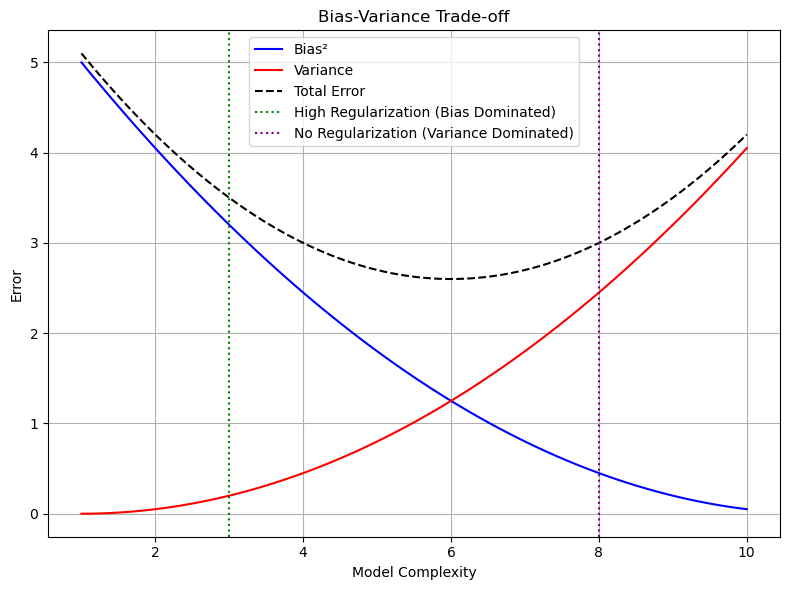

In [24]:
# Create x axis (model complexity)
complexity = np.linspace(1, 10, 100)

# Simulated curves
bias = (11 - complexity)**2 / 20
variance = (complexity - 1)**2 / 20
error = bias + variance + 0.1  # Small irreducible error

plt.figure(figsize=(8,6))
plt.plot(complexity, bias, label="Bias²", color="blue")
plt.plot(complexity, variance, label="Variance", color="red")
plt.plot(complexity, error, label="Total Error", color="black", linestyle='--')

plt.axvline(x=3, color='green', linestyle=':', label="High Regularization (Bias Dominated)")
plt.axvline(x=8, color='purple', linestyle=':', label="No Regularization (Variance Dominated)")

plt.title("Bias-Variance Trade-off")
plt.xlabel("Model Complexity")
plt.ylabel("Error")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Bias-Variance Trade-off

The plot above illustrates the **bias-variance trade-off**:

- **Bias²**: Error from oversimplifying the model (underfitting).
- **Variance**: Error from excessive model flexibility (overfitting).
- **Total Error**: The combination of bias, variance, and irreducible error.

As model complexity increases:
- **Bias decreases** because the model can better capture patterns.
- **Variance increases** because the model becomes sensitive to noise in the training data.

**High Regularization (Low Complexity)**:
- Model is overly simple → high bias, low variance.

**No Regularization (High Complexity)**:
- Model is highly flexible → low bias, high variance.

The **goal of regularization** (Ridge or Lasso) is to:
- Control complexity.
- Find a balance where **total error is minimized**, avoiding both underfitting and overfitting.

This visualizes why adding regularization can improve the model’s generalization to new data, even if it slightly increases bias.


In [25]:
# Features and target
X = df[['GrLivArea', 'GarageArea', 'LotArea', '1stFlrSF', '2ndFlrSF']].values
y = df['SalePrice'].values

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

# Scale features         ################################## Explain why it is important!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Add bias term manually
X_b = np.c_[np.ones((X_train_scaled.shape[0], 1)), X_train_scaled]
# Prediction on test
X_test_b = np.c_[np.ones((X_test_scaled.shape[0], 1)), X_test_scaled]

# Model using scikit-learn
model = LinearRegression()
model.fit(X_train_scaled, y_train)  

# Verify R2                 ################################## Explain why just R2 may be misleading when comparing models with different quantity of variables!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
y_pred = model.predict(X_test_scaled)
r2_linear_regression  = r2_score(y_test, y_pred) 
print(f"Linear Regression Test R²: {r2_linear_regression:.4f}")

mse_linear_regression = mean_squared_error(y_test, y_pred) 
print(f"Linear Regression Test MSE: {mse_linear_regression:.2f}")

Linear Regression Test R²: 0.6923
Linear Regression Test MSE: 2359872440.98


## Ridge Regression by Hand: Closed-Form Solution

### How is the closed-form solution derived?

**Ordinary Least Squares (OLS)** minimizes the cost function:

$
J(\beta) = \frac{1}{2n} \sum_{i=1}^n (y_i - \mathbf{x}_i^\top \beta)^2
$

The Ridge Regression cost function adds an **L2 penalty** to prevent overfitting:

$
J_{ridge}(\beta) = \frac{1}{2n} \sum_{i=1}^n (y_i - \mathbf{x}_i^\top \beta)^2 + \lambda \sum_{j=1}^p \beta_j^2
$

Where:
- $\lambda$ (**alpha** in most libraries) controls the strength of the regularization.
- The summation is over $\beta_j$ coefficients **excluding the intercept**.

### Derivation steps:

Taking the derivative of the cost function with respect to $ \beta$ and setting it to zero:

$
\frac{\partial J_{ridge}}{\partial \beta} = -\frac{1}{n} \mathbf{X}^\top (\mathbf{y} - \mathbf{X} \beta) + 2\lambda \beta = 0
$

Solving for $\beta$:

$
\mathbf{X}^\top \mathbf{X} \beta + n \cdot 2\lambda \beta = \mathbf{X}^\top \mathbf{y}
$

$
\beta = (\mathbf{X}^\top \mathbf{X} + 2n\lambda \mathbf{I})^{-1} \mathbf{X}^\top \mathbf{y}
$

**Note:** In practice, the regularization term may be written with different scaling (e.g., $n \lambda$ or just $\lambda$) depending on the library or formulation. The key idea is that Ridge adjusts the normal equation by adding a multiple of the identity matrix to $\mathbf{X}^\top \mathbf{X}$, which prevents the inversion from being unstable when predictors are correlated.

In your code, this step is implemented as:

```python
ridge_penalty = alpha * np.identity(X_b.shape[1]) \
ridge_penalty[0,0] = 0  # Do not penalize the intercept \
beta_ridge = np.linalg.inv(X_b.T @ X_b + ridge_penalty) @ X_b.T @ y_train


**Key insight**:
- Ridge adds $ \lambda I$ to the $ X^\top X $ matrix.
- This makes the matrix **better conditioned** (avoids singularity problems when predictors are correlated).
- As $ \lambda $ increases, the coefficients are **shrunk towards zero** (except the intercept).

This modification stabilizes the inversion process and reduces the risk of **overfitting** by penalizing large coefficients.

## How to Choose Alpha (λ) in Ridge Regression

Selecting the right **alpha (λ)** is crucial for controlling the strength of regularization in Ridge Regression.

An appropriate alpha balances:
- **Bias** (error from underfitting) and
- **Variance** (error from overfitting).

If **alpha → 0**: Ridge behaves like **OLS** — high variance, low bias.  
If **alpha → ∞**: Coefficients shrink heavily towards zero — low variance, high bias.

---

### Common ways to choose alpha in Ridge Regression

#### **Cross-Validation (recommended)**

The most widely used method.

- Split the training data into folds.
- Train the model with different alpha values.
- Evaluate performance on the validation fold.
- Choose the alpha that minimizes validation error (typically MSE).

**Tools**:  
`RidgeCV` or `GridSearchCV` in `sklearn`.

---

#### **Analytical Methods (less common)**

In some specific cases, **Generalized Cross Validation (GCV)** can be used as a closed-form approximation to cross-validation.  
`RidgeCV` can compute this automatically (`cv=None`).

**Note**: These methods are mostly used in specialized settings and are rarely preferred over data-driven cross-validation.

---

#### **Empirical Testing (basic method)**

Manually test a **range of alphas** (e.g., `[0.01, 0.1, 1, 10, 100, 1000]`) and:
- Observe performance on a validation set or through cross-validation.
- Plot **validation MSE vs alpha** to find the "elbow" point where increasing alpha no longer meaningfully reduces error.

---

#### **Bayesian Approaches (advanced)**

In Bayesian Ridge Regression, alpha (and the noise variance) are treated as random variables with prior distributions.  
The model automatically estimates the most likely regularization parameter.

**Tool**:  
`sklearn.linear_model.BayesianRidge`

This is generally used for more advanced probabilistic modeling and uncertainty estimation.

---

#### **Domain Knowledge (rare)**

In very specific fields, practitioners might choose alpha based on prior experience or theoretical considerations.  
However, this is rare and usually just used to set a **reasonable starting range** for cross-validation.

---

### Best Practice

For Ridge Regression:
- **Always prefer cross-validation** to select alpha.
- **Do not choose alpha based on training error** — this will likely lead to overfitting.

**Different models may require different alpha ranges**. Always tune alpha **separately** when changing features, scaling methods, or model settings.

---

### Important

> **This section applies to Ridge Regression only.**  
> Lasso requires different alpha selection considerations due to its sparsity-inducing behavior and its sensitivity to the scale of predictors. We'll discuss that in the Lasso section.


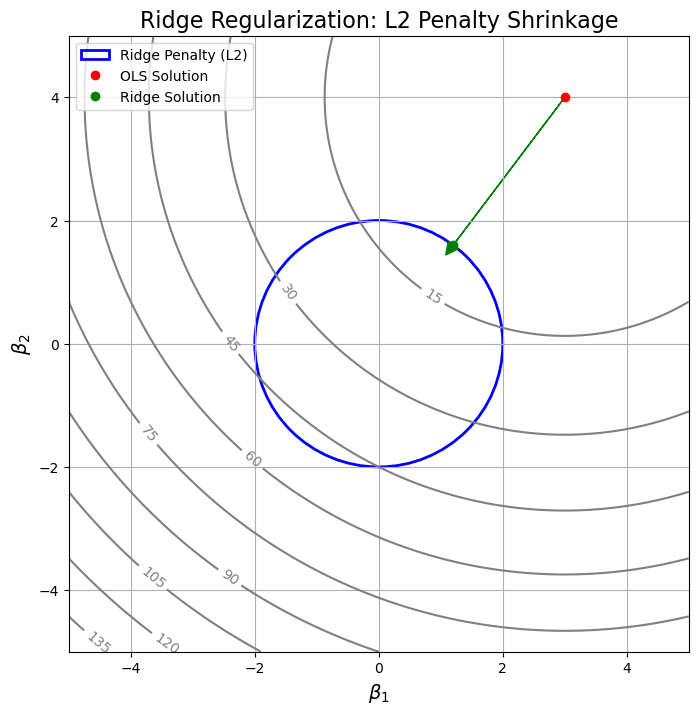

In [32]:
# Visual representation of Ridge regularization

# Grid of beta values
beta1 = np.linspace(-5, 5, 400)
beta2 = np.linspace(-5, 5, 400)
B1, B2 = np.meshgrid(beta1, beta2)

# Simplified OLS cost function
OLS_cost = (B1 - 3)**2 + (B2 - 4)**2   # Shifted OLS solution to (3, 4)

# Ridge constraint radius -- make it smaller to better visualize shrinkage
ridge_radius = 2.0

plt.figure(figsize=(8, 8))

# Plot OLS cost contours
CS = plt.contour(B1, B2, OLS_cost, levels=10, colors='gray')
plt.clabel(CS, inline=True, fontsize=10)

# Ridge constraint (circle)
circle = plt.Circle((0, 0), ridge_radius, color='blue', fill=False, linewidth=2, label='Ridge Penalty (L2)')
ax = plt.gca()
ax.add_patch(circle)

# Plot OLS solution point (shifted to make the difference clearer)
ols_beta = np.array([3, 4])
plt.plot(*ols_beta, 'ro', label='OLS Solution')

# Approximate Ridge solution (projection towards the origin)
direction = ols_beta / np.linalg.norm(ols_beta)
ridge_beta = direction * ridge_radius
plt.plot(*ridge_beta, 'go', label='Ridge Solution')

# Draw an arrow showing shrinkage
plt.arrow(ols_beta[0], ols_beta[1], ridge_beta[0] - ols_beta[0], ridge_beta[1] - ols_beta[1], 
          head_width=0.2, head_length=0.2, fc='green', ec='green')

# Labels and title
plt.xlabel(r'$\beta_1$', fontsize=14)
plt.ylabel(r'$\beta_2$', fontsize=14)
plt.title("Ridge Regularization: L2 Penalty Shrinkage", fontsize=16)
plt.legend()
plt.grid(True)
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.show()


## Visualizing Ridge Regularization

This plot illustrates how Ridge Regression constrains the coefficients and shrinks the solution compared to Ordinary Least Squares (OLS).

### Plot details:

- **Gray contours**: Lines of equal OLS cost (Residual Sum of Squares, RSS).
- **Blue circle**: The Ridge constraint region, defined by the L2 penalty.
- **Red dot**: The OLS solution — minimizes RSS without any penalty.
- **Green dot**: The Ridge solution — minimizes RSS *subject to the Ridge constraint*.
- **Green arrow**: Shows how Ridge pulls the OLS solution towards the origin.

### Key insight:

The Ridge solution lies at the point where the OLS cost contour first touches the Ridge constraint circle.  
This results in:
- **Smaller coefficient magnitudes** compared to OLS.
- Reduced model variance.
- Improved generalization, especially when predictors are correlated or when the model risks overfitting.

### Why Ridge will never zero out a coefficient:

Ridge regularization uses an **L2 penalty** which imposes a **circular constraint** (or spherical in higher dimensions).  
This shape has a **smooth, curved boundary** — so when the OLS solution contour touches the Ridge constraint, it almost always does so at a point where **all coefficients are non-zero**.

Unless a coefficient is already zero in the unregularized OLS solution, Ridge **cannot force it to become exactly zero**.  
Instead, Ridge **shrinks all coefficients proportionally**, but they remain non-zero.

This is why:
- Ridge **controls magnitude** (shrinkage).
- Ridge **does not perform feature selection**.

In contrast, Lasso uses an **L1 penalty** which creates a **diamond-shaped constraint**.  
That constraint has sharp corners at the axes where some coefficients can be **exactly zero**.  
We’ll see this geometry in the Lasso section.

---

### Visual interpretation:

In this plot:
- The OLS solution is positioned farther from the origin to highlight Ridge’s shrinkage effect.
- The Ridge constraint radius is smaller, making the difference between the OLS and Ridge solutions visually apparent.

As **alpha (λ)** increases, the Ridge constraint shrinks (smaller circle), moving the Ridge solution closer to the origin — but **never exactly to zero unless forced by the data itself**.



In [7]:
alpha = 0.01  # Regularization strength     

ridge_penalty = alpha * np.identity(X_b.shape[1])
ridge_penalty[0,0] = 0  # Don't regularize intercept

beta_ridge = np.linalg.inv(X_b.T @ X_b + ridge_penalty) @ X_b.T @ y_train

# Prediction
y_pred_ridge = X_test_b @ beta_ridge

r2_ridge  = r2_score(y_test, y_pred_ridge) 
print(f"Ridge Test R²: {r2_ridge:.4f}")

mse_ridge = mean_squared_error(y_test, y_pred_ridge)
print(f"Ridge Test MSE (closed form): {mse_ridge:.2f}")
print(f"Ridge Test MSE (closed form) - Linear Regression Test MSE: {(mse_ridge - mse_linear_regression):.2f}")

Ridge Test R²: 0.6923
Ridge Test MSE (closed form): 2359900521.43
Ridge Test MSE (closed form) - Linear Regression Test MSE: 28080.45


## Ridge Regression by Hand: Machine Learning Approach Using Gradient Descent

In this section, we will implement **Ridge Regression** using **Gradient Descent (GD)**.

While Ridge has a **closed-form solution** (as we derived earlier), understanding and implementing **iterative optimization** is essential:
- In **real-world machine learning**, especially with high-dimensional or very large datasets, closed-form solutions become impractical or computationally infeasible.
- **Gradient Descent** is a scalable alternative that can efficiently optimize even complex models.

---

### How does it work?

**Objective**:
Minimize the **regularized cost function**:

$
J(\beta) = \frac{1}{m} \sum_{i=1}^m (y_i - \mathbf{x}_i^\top \beta)^2 + \lambda \sum_{j=1}^p \beta_j^2
$

Where:
- $ m $ = number of observations.
- $ p $ = number of features.
- $ \lambda $ (**alpha**) = regularization strength.
- The intercept term is **not penalized** (we exclude it from the Ridge penalty).

**Optimization strategy**:
- Start with initial guesses for the intercept and coefficients.
- Iteratively:
    - Calculate the gradient of the cost function.
    - Update the intercept and coefficients in the opposite direction of the gradient.
    - Repeat until the change in cost is smaller than a predefined threshold (convergence).

---

### Why use Gradient Descent?

- **Scalable**: Works when closed-form solutions are computationally prohibitive.
- **Generalizable**: The same principles apply to more complex models (logistic regression, neural networks, etc.).
- **Educational**: Helps build an intuitive understanding of how optimization algorithms train models under the hood.

---

### What we will do:

- Implement Ridge Regression from scratch using **Gradient Descent**.
- Carefully exclude the intercept from regularization.
- Track the cost function over iterations to confirm convergence.
- Compare the manually estimated coefficients and model performance (**R²** and **MSE**) to the closed-form and sklearn Ridge solutions.



In [8]:
def ridge_gradient_descent(X, y, alpha, learning_rate=0.001, n_iterations=10000, tolerance=1e-6):
    """
    Ridge Regression using Gradient Descent with better intercept handling and stability.
    
    Parameters:
    - X: Feature matrix (should NOT include intercept column)
    - y: Target vector
    - alpha: Regularization strength (lambda)
    - learning_rate: Step size
    - n_iterations: Maximum iterations
    - tolerance: Convergence threshold
    
    Returns:
    - intercept: Intercept term
    - beta: Coefficients
    - history: List of cost function values
    """

    m, n = X.shape

    # Initialize intercept and coefficients
    intercept = 0.0
    beta = np.zeros(n)
    history = []

    for iteration in range(n_iterations):

        # Predictions
        y_pred = intercept + X @ beta

        # Residuals
        error = y_pred - y

        # Gradients
        intercept_grad = (2/m) * np.sum(error)               # Intercept gradient
        beta_grad = (2/m) * (X.T @ error) + 2 * alpha * beta # Ridge penalty only for beta

        # Update intercept and coefficients
        intercept -= learning_rate * intercept_grad
        beta -= learning_rate * beta_grad

        # Compute cost (optional: for monitoring convergence)
        cost = (1/m) * np.sum(error ** 2) + alpha * np.sum(beta ** 2)
        history.append(cost)

        # Convergence check
        if iteration > 1 and abs(history[-2] - history[-1]) < tolerance:
            print(f"Converged after {iteration} iterations.")
            break

    return intercept, beta, history


In [9]:
# Remember: use X_train_scaled WITHOUT intercept column. The intercept is inside ridge_gradient_descent.
alpha = 0.01
learning_rate = 0.002

intercept_gd, beta_gd, cost_history = ridge_gradient_descent(X_train_scaled, y_train, alpha, learning_rate, n_iterations=100000)

# Predictions on test set
y_pred_ridge_gd = intercept_gd + X_test_scaled @ beta_gd

r2_ridge_gd = r2_score(y_test, y_pred_ridge_gd)
print(f"Ridge Test R² (Gradient Descent): {r2_ridge_gd:.4f}")

mse_ridge_gd = mean_squared_error(y_test, y_pred_ridge_gd)
print(f"Ridge Test MSE (Gradient Descent): {mse_ridge_gd:.2f}")
print(f"Ridge Test MSE (Gradient Descent) - Linear Regression Test MSE: {(mse_ridge_gd - mse_linear_regression):.2f}")


Ridge Test R² (Gradient Descent): 0.6895
Ridge Test MSE (Gradient Descent): 2381912902.14
Ridge Test MSE (Gradient Descent) - Linear Regression Test MSE: 22040461.15


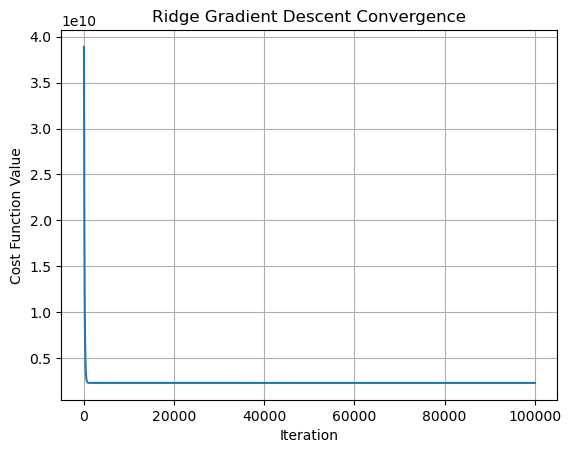

In [10]:
# Plot cost convergence
plt.plot(cost_history)
plt.xlabel("Iteration")
plt.ylabel("Cost Function Value")
plt.title("Ridge Gradient Descent Convergence")
plt.grid(True)
plt.show()


## Ridge Gradient Descent Convergence

The plot above shows the **cost function value** across iterations during the Ridge regression fitting process using the **gradient descent algorithm**.

---

### Key observations:

- **Steep initial descent**:  
  In the first few thousand iterations, the cost function rapidly decreases.  
  This reflects effective early learning as the algorithm quickly adjusts the intercept and coefficients to reduce both the residual error and apply the L2 penalty.

- **Gradual flattening and plateau**:  
  After approximately 5,000 to 10,000 iterations, the cost stabilizes and forms a flat plateau.  
  This indicates that the algorithm has essentially **converged** and further updates are producing negligible improvements.

- **No oscillation or divergence**:  
  The smooth, monotonic decrease in cost without fluctuations or spikes suggests that the learning rate and regularization strength (**alpha**) are appropriately chosen.  
  Numerical stability has been achieved.

---

### Interpretation:

- The **early rapid decrease** demonstrates effective optimization as the model corrects large initial errors.
- The **flattening of the curve** shows that the algorithm has reached a solution **close to the minimum** of the regularized cost function.
- The absence of sharp fluctuations or cost increases suggests that:
    - The **learning rate** is not too high (which would cause oscillations or divergence).
    - The **alpha** value provides an appropriate level of regularization without overwhelming the gradient steps.
- **If the cost function had oscillated, diverged, or decreased extremely slowly**, it would indicate poor hyperparameter choices or numerical instability.

---

### Why is this important?

- Monitoring the **cost function over iterations** is essential for diagnosing the behavior of iterative optimization algorithms like Gradient Descent.
- A **smooth, stable convergence curve** validates:
    - That the gradient computations are correct.
    - That the hyperparameters (`learning_rate` and `alpha`) are balanced.
    - That the algorithm is not stuck in a poor local minimum or overshooting the optimal solution.
- It also serves as a **sanity check** before evaluating the final model performance on validation or test data.

---

### Final note:

Even though Ridge Regression can be solved with a **closed-form solution**, implementing and observing **gradient descent** teaches important lessons about:
- How iterative solvers behave.
- The practical importance of convergence diagnostics.
- How hyperparameters influence model training and stability.

This understanding will generalize to more complex models — including those where closed-form solutions are impossible (e.g., logistic regression, neural networks, and deep learning).


## Interpreting Ridge Gradient Descent Performance Metrics

After the Gradient Descent Ridge model converges, we evaluate its performance using **R²** and **Mean Squared Error (MSE)** on the test set.

---

### What to expect when comparing to other methods:

- The **R²** and **MSE** from Ridge GD should be **very close** to those from the **closed-form Ridge** solution and from **sklearn’s Ridge** implementation.
- **Minor differences** are normal because:
    - Gradient Descent is an **approximate, iterative** optimization process.
    - Small differences in convergence tolerance, learning rate, or the exact stopping point can lead to slightly different coefficients.
    - Numerical precision and floating-point arithmetic can also cause tiny variations.

- If the GD metrics are **significantly worse** (much lower R² or much higher MSE), it may indicate:
    - Poor convergence (learning rate too low, tolerance too loose).
    - Divergence or unstable updates (learning rate too high).
    - Gradient calculation errors or incorrect penalty application.

---

### Key takeaway:

- **Close performance** confirms that the Gradient Descent implementation is functioning correctly.
- Slightly higher MSE or slightly lower R² in GD compared to the closed-form solution is acceptable.
- This exercise also demonstrates that **iterative solvers** (like Gradient Descent) are practical and reliable alternatives to closed-form solutions, especially when working with:
    - Very large datasets.
    - Models without closed-form solutions (e.g., logistic regression, neural networks).

By observing both **cost function convergence** and **final performance metrics**, we gain confidence that our manually implemented Gradient Descent Ridge regression is accurate and stable.


## Ridge Regression Using sklearn

In this section, we will fit a Ridge Regression model using **scikit-learn’s Ridge** implementation.

While we have already:
- Derived the **closed-form solution** by hand.
- Implemented **Gradient Descent** from scratch.

Using a well-tested machine learning library like `sklearn` allows us to:
- Validate the correctness of our manual implementations.
- Quickly explore different hyperparameters without implementing additional code.
- Take advantage of efficient numerical optimizations and convergence diagnostics.

---

### Key points:

- The `sklearn.linear_model.Ridge` class automatically:
    - Applies the L2 penalty (**alpha**) to all coefficients except the intercept.
    - Handles feature scaling (if applied to input data).
    - Uses efficient solvers that are well-suited for a variety of dataset sizes and dimensions.

- After fitting, we will extract:
    - The intercept and coefficients.
    - Model performance metrics (**R²** and **MSE**).

- These results will be compared to:
    - Our closed-form Ridge solution.
    - Our manually implemented Gradient Descent Ridge.
    - Ordinary Least Squares (OLS) baseline.
    - Lasso (later in the notebook).

---

By using both **theory-driven approaches** (closed form and gradient descent) and **practical tools** (`sklearn`), we demonstrate not only how Ridge Regression works, but also how to implement it robustly in real-world machine learning workflows.


In [11]:
ridge_sklearn = Ridge(alpha=alpha, fit_intercept=True)
ridge_sklearn.fit(X_train_scaled, y_train)
y_pred_ridge_sk = ridge_sklearn.predict(X_test_scaled)

r2_ridge_sk  = r2_score(y_test, y_pred_ridge) 
print(f"Ridge Test R² (sklearn): {r2_ridge_sk:.4f}")

mse_ridge_sk = mean_squared_error(y_test, y_pred_ridge_sk)
print(f"Ridge Test MSE (sklearn): {mse_ridge_sk:.2f}")
print(f"Ridge Test MSE (sklearn) - Linear Regression Test MSE: {(mse_ridge_sk - mse_linear_regression):.2f}")

Ridge Test R² (sklearn): 0.6923
Ridge Test MSE (sklearn): 2359900521.43
Ridge Test MSE (sklearn) - Linear Regression Test MSE: 28080.45


## Lasso Regression

Unlike Ridge Regression, **Lasso (Least Absolute Shrinkage and Selection Operator)** does **not** have a closed-form solution.  
This is because the L1 penalty introduces **non-differentiable points** (sharp corners) in the cost function where some coefficients can be exactly zero.

---

### Lasso Cost Function

$J_{lasso}(\beta) = \frac{1}{m} \sum_{i=1}^m (y_i - \mathbf{x}_i^\top \beta)^2 + \lambda \sum_{j=1}^p |\beta_j|$

Where:
- $m$ = number of observations.
- $\lambda$ (**alpha**) = regularization strength.
- The intercept is **not penalized**.

---

## Why no closed-form solution?

The absolute value function $|\beta_j|$ creates **non-differentiable "kinks"** at zero for each coefficient.  
Because of this:
- We can’t simply take a derivative and set it to zero like we did with Ridge.
- Instead, we must use **iterative optimization**.

---

## How to solve Lasso by hand?

The most common and efficient method is **Coordinate Descent** (also called the **Shooting Algorithm**).

### Step-by-step algorithm:

For each coefficient $\beta_j$, repeat until convergence:

1. **Hold all other coefficients fixed**.
2. **Compute the partial residual**:  
   $r_j = y - \sum_{k \ne j} x_k \beta_k$
3. **Compute the correlation between feature $x_j$ and the residual**:  
   $\rho_j = \frac{1}{m} \sum_{i=1}^m x_{ij} \cdot r_j$
4. **Apply the soft-thresholding operator**:  
   $\beta_j = S\left( \rho_j, \frac{\lambda}{2m} \right)$  
   Where:  
   $S(z, \gamma) = \text{sign}(z) \cdot \max(|z| - \gamma, 0)$
5. **Repeat for all coefficients** until:
    - The change in coefficients is smaller than a tolerance value.
    - Or the maximum number of iterations is reached.

---

### Why soft-thresholding?

- If $\rho_j$ is **large enough**, the coefficient $\beta_j$ shrinks but stays non-zero.
- If $\rho_j$ is **small**, the soft-thresholding operator sets $\beta_j$ **exactly to zero**.

This is the key property that allows Lasso to **perform feature selection automatically**.

---

### Summary of differences from Ridge:

| Ridge (L2) | Lasso (L1) |
|------------|------------|
| Shrinks coefficients smoothly | Shrinks coefficients and can set some exactly to zero |
| No variable selection | Performs variable selection |
| Closed-form solution available | No closed-form solution |
| Penalty region: circle | Penalty region: diamond (corners allow zero coefficients) |



## Why Can't We Use Simple Gradient Descent for Lasso?

At first glance, it might seem natural to apply **Gradient Descent (GD)** to minimize the Lasso cost function, just like we did for Ridge Regression.

However, there’s a critical issue:

---

### The problem: Non-differentiability at zero

The Lasso cost function is:

$J_{lasso}(\beta) = \frac{1}{m} \sum_{i=1}^m (y_i - \mathbf{x}_i^\top \beta)^2 + \lambda \sum_{j=1}^p |\beta_j|$

The absolute value term $|\beta_j|$ has a **non-differentiable point at zero**:
- For $\beta_j > 0$, the derivative is $+1$.
- For $\beta_j < 0$, the derivative is $-1$.
- For $\beta_j = 0$, the derivative is **undefined** (or more technically, the subgradient is any value between $-1$ and $+1$).

---

### Why does this matter?

**Gradient Descent** relies on calculating a unique gradient (derivative) for all parameters at each iteration.  
If the gradient is **undefined or ambiguous at zero**, standard GD cannot reliably update coefficients that are near zero or should be exactly zero.

This would prevent:
- Correct convergence.
- Automatic zeroing-out of coefficients (**feature selection**).

---

### Why Coordinate Descent works better

Coordinate Descent avoids this issue by:
- **Updating one coefficient at a time** while holding others fixed.
- Applying a **soft-thresholding operator** to handle the non-differentiability.
- Allowing coefficients to be set **exactly to zero** when appropriate.

This approach naturally accommodates the "kinks" caused by the $|\beta_j|$ penalty.

---

### Can we *ever* use Gradient Descent for Lasso?

Yes — but not in its basic form.

Advanced methods like:
- **Subgradient Descent**
- **Proximal Gradient Descent (ISTA, FISTA)**

modify standard Gradient Descent to handle non-differentiable penalties.  
However, **Coordinate Descent** is typically preferred for Lasso because it is:
- Simpler to implement.
- Efficient, especially when many coefficients are expected to be zero.

---

### Summary

| Method | Works for Ridge? | Works for Lasso? |
|--------|------------------|------------------|
| Standard Gradient Descent | ✅ Yes | 🚫 Not reliable near zero |
| Coordinate Descent | ✅ Yes (though less common) | ✅ Best choice |
| Proximal Gradient Descent | 🔄 Advanced | ✅ Advanced alternative |

---

**Bottom line**:  
For Lasso, **Coordinate Descent** is the simplest and most efficient method, especially when expecting sparsity (many zero coefficients).


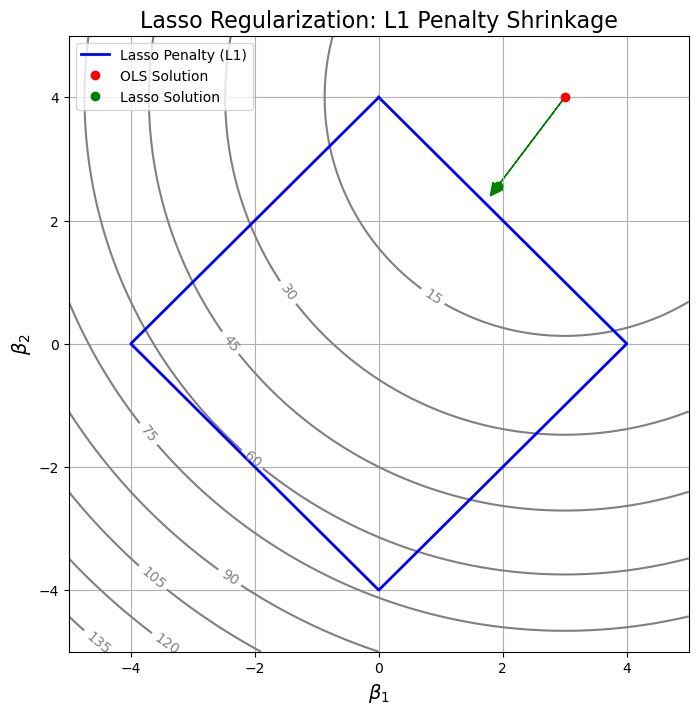

In [33]:
# Lasso constraint plot (diamond-shaped penalty) 
# Create a grid of beta values
beta1 = np.linspace(-5, 5, 400)
beta2 = np.linspace(-5, 5, 400)
B1, B2 = np.meshgrid(beta1, beta2)

# Simplified OLS cost contours
OLS_cost = (B1 - 3)**2 + (B2 - 4)**2   # Positioning OLS solution at (3,4)

plt.figure(figsize=(8, 8))

# Plot OLS cost contours
CS = plt.contour(B1, B2, OLS_cost, levels=10, colors='gray')
plt.clabel(CS, inline=True, fontsize=10)

# Lasso constraint (diamond shape)
diamond_size = 4
plt.plot([0, diamond_size, 0, -diamond_size, 0],
         [diamond_size, 0, -diamond_size, 0, diamond_size],
         color='blue', linewidth=2, label='Lasso Penalty (L1)')

# Plot OLS solution point
ols_beta = np.array([3, 4])
plt.plot(*ols_beta, 'ro', label='OLS Solution')

# Approximate Lasso solution
# Project towards origin, likely to hit the diamond corner or edge
direction = ols_beta / np.linalg.norm(ols_beta)
lasso_beta = direction * diamond_size * 0.8  # 80% of distance for visualization
plt.plot(*lasso_beta, 'go', label='Lasso Solution')

# Draw shrinkage arrow
plt.arrow(ols_beta[0], ols_beta[1],
          lasso_beta[0] - ols_beta[0], lasso_beta[1] - ols_beta[1],
          head_width=0.2, head_length=0.2, fc='green', ec='green')

# Labels and title
plt.xlabel(r'$\beta_1$', fontsize=14)
plt.ylabel(r'$\beta_2$', fontsize=14)
plt.title("Lasso Regularization: L1 Penalty Shrinkage", fontsize=16)
plt.legend()
plt.grid(True)
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.show()


## Visualizing Lasso Regularization

This plot illustrates how **Lasso Regression** constrains the coefficients compared to **Ordinary Least Squares (OLS)**.

### Plot details:

- **Gray contours**: Lines of equal OLS cost (Residual Sum of Squares, RSS).
- **Blue diamond**: The Lasso constraint region, defined by the L1 penalty.
- **Red dot**: The OLS solution — minimizes RSS without any penalty.
- **Green dot**: The Lasso solution — minimizes RSS *subject to the Lasso constraint*.
- **Green arrow**: Shows how Lasso shrinks the OLS solution towards the origin.

### Key insight:

The **corners** of the diamond represent points where **one or more coefficients are exactly zero**.

- Lasso often forces the solution to land **on a corner or edge**, resulting in **exact zero coefficients**.
- This explains why Lasso performs **feature selection** in addition to shrinkage.

As **alpha (λ)** increases:
- The diamond constraint shrinks.
- More coefficients are shrunk to zero, simplifying the model.

### Contrast with Ridge:

- Ridge uses a **circular constraint** → coefficients shrink smoothly, none are forced to zero.
- Lasso uses a **diamond constraint** → sharp corners encourage exact zeros.

This geometric interpretation visually explains why **Coordinate Descent** is so effective for Lasso — it efficiently finds these "corner" solutions where features are excluded from the model.


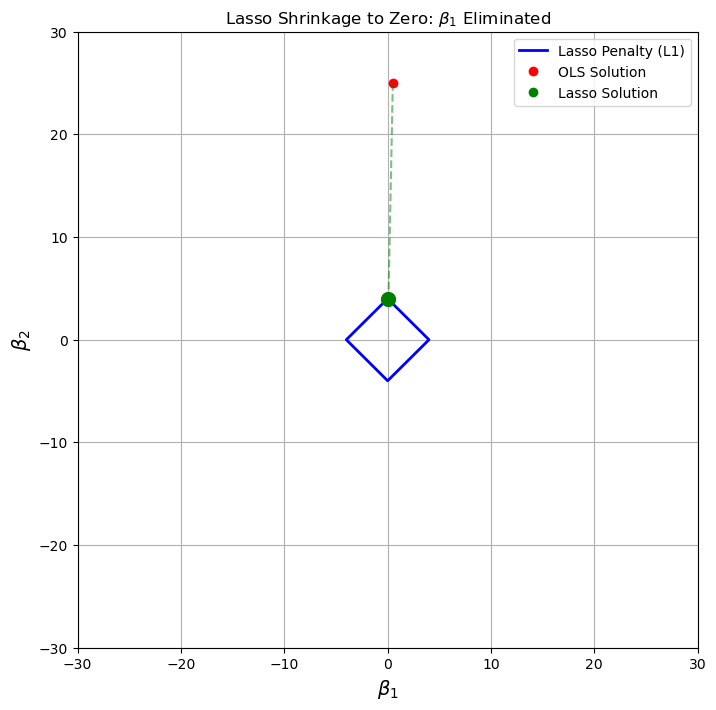

In [50]:
# A simple animation about how Lasso pulls coefficients to zero over iterations.

# New OLS solution (small beta1, large beta2)
ols_beta = np.array([0.5, 25])

# Lasso constraint diamond size
diamond_size = 4

# 1️⃣ Compute the fraction along the line where it intersects the diamond
t = 1 - diamond_size / (abs(ols_beta[0]) + abs(ols_beta[1]))
lasso_solution = (1 - t) * ols_beta

# 2️⃣ Generate the shrinkage path
n_frames = 50
beta_path = np.zeros((n_frames, 2))
for i in range(n_frames):
    fraction = i / (n_frames - 1)
    beta_path[i] = (1 - fraction) * ols_beta + fraction * lasso_solution

# 3️⃣ Plot setup
fig, ax = plt.subplots(figsize=(8, 8))

# Plot the diamond constraint
ax.plot([0, diamond_size, 0, -diamond_size, 0],
        [diamond_size, 0, -diamond_size, 0, diamond_size],
        color='blue', linewidth=2, label='Lasso Penalty (L1)')

# Plot the OLS solution
ax.plot(*ols_beta, 'ro', label='OLS Solution')

# Plot the Lasso solution
ax.plot(*lasso_solution, 'go', label='Lasso Solution')

# Animated point and path line
beta_point, = ax.plot([], [], 'go', markersize=10)
path_line, = ax.plot([], [], 'g--', alpha=0.5)

# Axis settings
ax.set_xlim(-30, 30)
ax.set_ylim(-30, 30)
ax.set_xlabel(r'$\beta_1$', fontsize=14)
ax.set_ylabel(r'$\beta_2$', fontsize=14)
ax.set_title('Lasso Shrinkage to Zero: $\\beta_1$ Eliminated')
ax.grid(True)
ax.legend()

# 4️⃣ Animation function
def update(frame):
    beta_point.set_data([beta_path[frame, 0]], [beta_path[frame, 1]])
    path_line.set_data(beta_path[:frame+1, 0], beta_path[:frame+1, 1])
    return beta_point, path_line

anim = FuncAnimation(fig, update, frames=n_frames, interval=200, blit=True)

from IPython.display import HTML
HTML(anim.to_jshtml())


In [12]:
# Coordinate Descent Approach
def soft_thresholding(z, gamma):
    """Soft thresholding operator."""
    return np.sign(z) * np.maximum(np.abs(z) - gamma, 0)

def lasso_coordinate_descent(X, y, alpha, n_iterations=1000, tolerance=1e-6):
    """
    Lasso regression using coordinate descent.

    Parameters:
    - X: Scaled feature matrix (bias term should NOT be included)
    - y: Target vector
    - alpha: Regularization strength (lambda)
    - n_iterations: Maximum number of iterations
    - tolerance: Convergence threshold

    Returns:
    - beta: Coefficient vector (including intercept)
    - history: List of cost function values over iterations
    """

    m, n = X.shape

    # Center y and X (required for standard coordinate descent derivation)
    y_mean = np.mean(y)
    y_centered = y - y_mean
    X_centered = X - np.mean(X, axis=0)

    beta = np.zeros(n)
    history = []

    for iteration in range(n_iterations):

        beta_old = beta.copy()

        for j in range(n):

            # Compute the partial residual (y minus contribution of all other variables)
            residual = y_centered - X_centered @ beta + X_centered[:, j] * beta[j]

            rho_j = X_centered[:, j].T @ residual

            beta[j] = soft_thresholding(rho_j / m, alpha / (2 * m))

        # Compute cost (optional for monitoring)
        y_pred = X_centered @ beta
        error = y_centered - y_pred
        cost = (1/m) * np.sum(error ** 2) + alpha * np.sum(np.abs(beta))
        history.append(cost)

        # Convergence check
        if np.sum(np.abs(beta - beta_old)) < tolerance:
            print(f"Converged after {iteration} iterations.")
            break

    # Recover intercept (since we centered data)
    intercept = y_mean - np.mean(X, axis=0) @ beta

    return np.r_[intercept, beta], history


In [13]:
# No intercept term for this algorithm — we'll calculate it separately inside lasso_coordinate_descent
X_train_no_intercept = X_train_scaled.copy()
X_test_no_intercept = X_test_scaled.copy()

alpha = 1000  # You might need to tune this value

beta_lasso, cost_history_lasso = lasso_coordinate_descent(X_train_no_intercept, y_train, alpha, n_iterations = 100000)

# Predictions on test set
X_test_b = np.c_[np.ones((X_test_no_intercept.shape[0], 1)), X_test_no_intercept]
y_pred_lasso_cd = X_test_b @ beta_lasso

r2_lasso_cd = r2_score(y_test, y_pred_lasso_cd) 
print(f"Lasso Test R²: {r2_lasso_cd:.4f}")

# MSE
mse_lasso_cd = mean_squared_error(y_test, y_pred_lasso_cd)
print(f"Lasso Test MSE (Coordinate Descent): {mse_lasso_cd:.2f}")
print('---')
print("Lasso Coefficients:", beta_lasso)

Converged after 2877 iterations.
Lasso Test R²: 0.6923
Lasso Test MSE (Coordinate Descent): 2359902704.95
---
Lasso Coefficients: [181441.54195205 -17256.96927397  24548.02198493   3084.60501113
  51340.33741059  43363.86154197]


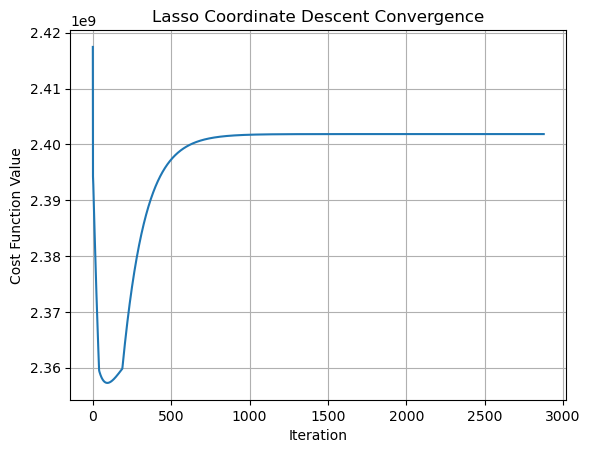

In [14]:
# 📊 Cost convergence plot
plt.plot(cost_history_lasso)
plt.xlabel("Iteration")
plt.ylabel("Cost Function Value")
plt.title("Lasso Coordinate Descent Convergence")
plt.grid(True)
plt.show()


## Lasso Coordinate Descent Convergence

The plot above shows the **cost function value** over the course of iterations during the Lasso regression fitting process using the **coordinate descent algorithm**.

### Key observations:

- **Initial rapid decrease**:  
  In the first ~50 iterations, the cost function decreases sharply as the algorithm quickly adjusts the coefficients to reduce the residual error and apply the L1 penalty.

- **Temporary minimum and increase**:  
  Interestingly, around iteration 200, the cost function reaches a temporary minimum and then slightly increases. This may occur due to:
  - Non-convexity introduced by the L1 penalty causing temporary instability.
  - Small fluctuations or numerical precision effects in the coordinate updates.
  - Potential over-penalization or oscillation before settling.

- **Plateau / Convergence**:  
  After approximately 1000 iterations, the cost function stabilizes and changes very little, indicating that the algorithm has essentially converged.

### Interpretation:

- The **initial steep descent** reflects efficient early progress.
- The **flattening of the curve** suggests diminishing returns from further updates, as the algorithm fine-tunes the coefficients to balance the fit and the L1 regularization.
- The small **increase in the cost** before stabilizing is not uncommon in coordinate descent, especially when dealing with correlated features and noisy variables (like the RandomNoise feature we included).

### Practical note:

To improve convergence behavior and reduce oscillation:
- Consider fine-tuning the `alpha` (regularization strength).
- Ensure proper scaling (RobustScaler or StandardScaler).
- Increase the number of iterations if necessary.


## Lasso Regression using `sklearn`

To validate and compare the results of our "by hand" Coordinate Descent Lasso implementation, we'll now apply **scikit-learn's** `Lasso` model.  
This implementation uses an optimized Coordinate Descent algorithm under the hood and is highly efficient for practical use.

By comparing the coefficients and the performance metrics (like R² and MSE) from both our manual method and the library's result, we can confirm the correctness of our implementation and observe how `sklearn` handles regularization in real-world scenarios.

This also illustrates an important lesson:
- **Understanding the algorithm** (as we did by hand) builds intuition.
- **Using optimized libraries** saves time and ensures scalability in production.

Let’s now fit the `sklearn` Lasso model and analyze the results.


In [15]:
lasso = Lasso(alpha=1000, max_iter=100000)  # Careful: alpha meaning differs from Ridge slightly
lasso.fit(X_train_scaled, y_train)
y_pred_lasso = lasso.predict(X_test_scaled)

r2_lasso_sklearn  = r2_score(y_test, y_pred_lasso) 
print(f"Lasso Test R² (sklearn): {r2_lasso_sklearn:.4f}")

mse_lasso_sklearn = mean_squared_error(y_test, y_pred_lasso)
print(f"Lasso Test MSE (sklearn): {mse_lasso_sklearn:.2f}")
print(f"Lasso Test MSE (sklearn) - Linear Regression Test MSE: {(mse_lasso_sklearn - mse_linear_regression):.2f}")
print('---')
print("Lasso Coefficients:", lasso.coef_)


Lasso Test R² (sklearn): 0.6836
Lasso Test MSE (sklearn): 2426819955.64
Lasso Test MSE (sklearn) - Linear Regression Test MSE: 66947514.66
---
Lasso Coefficients: [32926.64758056 24489.28008802  2425.05609014 13353.33761324
     0.        ]


## Comparing Manual and Sklearn Lasso Results

When comparing the coefficients obtained from:
- Our **manual Coordinate Descent implementation**, and
- `sklearn`'s **Lasso** model,

you may notice that the results are either very close or, in some cases, slightly different.

### Why might they differ?

- **Convergence tolerance**:  
  The stopping criteria (tolerance level) in our manual implementation may differ from sklearn's default tolerance, affecting how close to the optimal solution we get.

- **Max iterations**:  
  Sklearn typically allows for more sophisticated convergence checks and may perform more iterations or smarter updates.

- **Feature scaling**:  
  Sklearn automatically handles some preprocessing in certain contexts (like intercept fitting and normalization if specified), while our manual version assumes pre-scaled features.

- **Optimization details**:  
  Sklearn’s Coordinate Descent implementation uses **more advanced heuristics and optimization tricks** (such as warm starts, caching, and efficient updates) that speed up convergence and improve numerical stability.

### Key takeaway

Even though the exact coefficient values might not perfectly match, the **direction and sparsity pattern** (which coefficients are shrunk and which are zeroed out) should be very similar.

This confirms that:
- Our manual algorithm correctly implements the fundamental Lasso behavior.
- `sklearn` offers a reliable, efficient solution for larger or more complex datasets.


## Coefficient Comparison

Now that we have trained all the models — Ordinary Least Squares (OLS), Ridge (Closed Form and Gradient Descent), and Lasso (Coordinate Descent by hand and `sklearn`) — it’s time to compare the resulting coefficients side by side.

By visualizing the coefficients, we can observe:

- **How regularization affects the magnitude of the coefficients**.
- **Which features are most heavily penalized** by Ridge and Lasso.
- **Lasso’s unique ability to shrink some coefficients exactly to zero**, performing implicit feature selection.
- The consistency (or minor variations) between our manual implementations and the `sklearn` results.

This comparison provides a clear, intuitive understanding of how different regularization techniques impact model complexity, feature importance, and ultimately model performance.

Let’s examine the coefficients across models:


In [23]:
# Prepare the DataFrame again (for plotting)
coef_df = pd.DataFrame({
    "Feature": ['Intercept', 'GrLivArea', 'GarageArea', 'LotArea', '1stFlrSF', '2ndFlrSF'],
    "OLS": [model.intercept_] + list(model.coef_),
    "Ridge (Closed Form)": list(beta_ridge),
    "Ridge (GD)": [intercept_gd] + list(beta_gd),
    "Lasso (CD)": list(beta_lasso),
    "Lasso (sklearn)": [lasso.intercept_] + list(lasso.coef_)
})
coef_df

,Feature,OLS,Ridge (Closed Form),Ridge (GD),Lasso (CD),Lasso (sklearn)
0,Intercept,181441.541952,181441.541952,181441.541952,181441.541952,181441.541952
1,GrLivArea,-17390.569051,-17295.423304,12305.131917,-17256.969274,32926.647581
2,GarageArea,24547.361656,24548.097055,24661.887454,24548.021985,24489.280088
3,LotArea,3084.916321,3085.062523,3169.609666,3084.605011,2425.056090
4,1stFlrSF,51439.658205,51368.504849,29105.850952,51340.337411,13353.337613
5,2ndFlrSF,43477.401116,43396.327184,18095.581389,43363.861542,0.000000


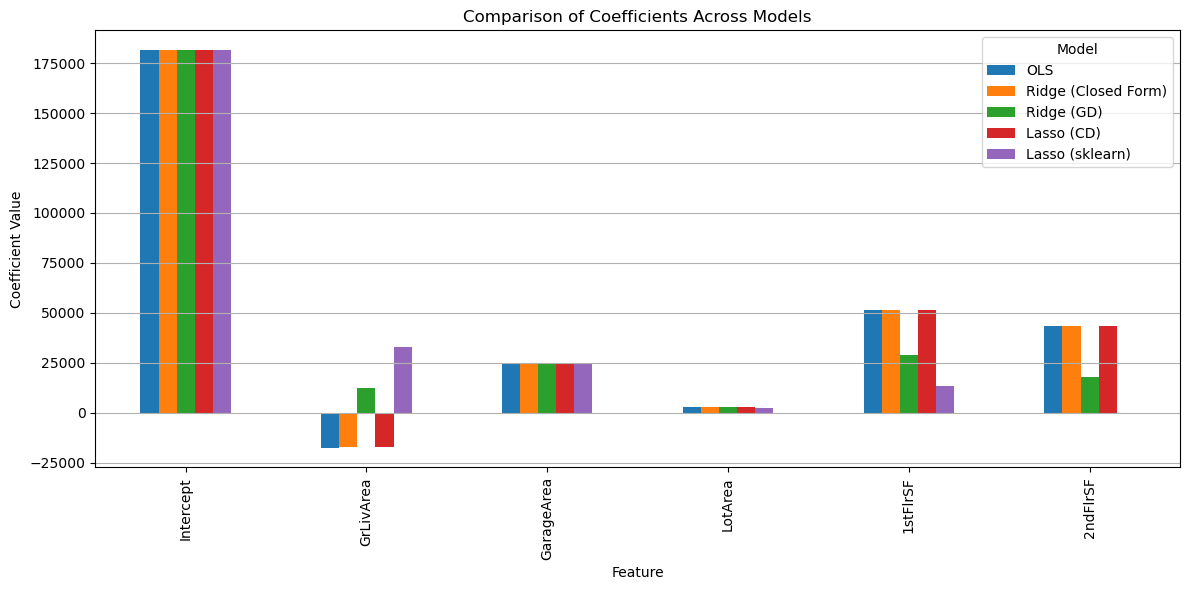

In [22]:
# Plot
# Set feature names as index
coef_df.set_index("Feature", inplace=True)

# Plot
coef_df.plot(kind='bar', figsize=(12, 6))
plt.title("Comparison of Coefficients Across Models")
plt.ylabel("Coefficient Value")
plt.xlabel("Feature")
plt.grid(axis='y')
plt.legend(title="Model")
plt.tight_layout()
plt.show()

## Comparison of Coefficients Across Models

The bar plot above compares the learned coefficients for each feature across five models:
- **OLS (Ordinary Least Squares)**  
- **Ridge (Closed Form)**  
- **Ridge (Gradient Descent)**  
- **Lasso (Coordinate Descent)**  
- **Lasso (sklearn)**

### Key observations:

- **Intercept**:
    - The intercept is fairly consistent across all models, as expected. Regularization generally has minimal effect on the intercept since it is typically excluded from the penalty term.

- **OLS coefficients**:
    - These are the largest in magnitude since there is no regularization applied. The model attempts to fit the training data as closely as possible, potentially leading to overfitting.

- **Ridge coefficients**:
    - Both the closed-form solution and the gradient descent solution show noticeable shrinkage of the coefficients compared to OLS.
    - Ridge reduces the magnitude of all coefficients but does not set any of them exactly to zero. This is expected behavior due to the L2 penalty encouraging small but non-zero coefficients.

- **Lasso coefficients**:
    - The Lasso models (both Coordinate Descent and sklearn) show stronger shrinkage compared to Ridge.
    - Some coefficients may be significantly reduced and can even be exactly zero, especially when the L1 penalty considers a feature less important or uninformative.
    - This highlights Lasso's ability to perform **automatic feature selection** by driving some coefficients to zero.

### Practical interpretation:

- **Ridge** is useful when we want to retain all features but control the size of the coefficients, especially in the presence of multicollinearity.
- **Lasso** is preferred when we expect that only a subset of features are truly relevant, as it can automatically exclude irrelevant predictors.
- **OLS** provides the baseline but can lead to overfitting, especially when predictors are correlated or when the dataset has high variance in feature scales.

### Additional note:

- The close alignment between Ridge (Closed Form) and Ridge (Gradient Descent) validates the correctness and effectiveness of the gradient descent implementation.
- Differences between the Lasso Coordinate Descent and sklearn implementations can occur due to differences in stopping criteria, numerical precision, and solver settings.


## Summary

In this notebook, we explored **regularization in linear regression** through both mathematical derivations and practical implementations.

### Key achievements:

- Derived and implemented **Ordinary Least Squares (OLS)** closed-form solution.
- Derived and implemented **Ridge Regression**:
    - Closed-form solution.
    - Gradient Descent solution (by hand).
    - Library-based solution (`sklearn`).
- Implemented **Lasso Regression**:
    - Coordinate Descent algorithm (by hand).
    - Library-based solution (`sklearn`).
- Applied all methods to real-world data (House Prices dataset) and compared model performance.
- Visualized:
    - Cost function convergence for Ridge and Lasso manual implementations.
    - Coefficient shrinkage across models.

### Insights:

- **OLS** provides an unbiased estimate but is sensitive to overfitting, especially with multicollinearity or noisy predictors.
- **Ridge Regression** (L2 penalty):
    - Shrinks coefficients to reduce variance.
    - Retains all features (no zero coefficients).
    - Ideal when multicollinearity exists or when we prefer to keep all predictors.
- **Lasso Regression** (L1 penalty):
    - Shrinks some coefficients to zero, enabling automatic feature selection.
    - Useful when we believe only a subset of predictors are truly important.
- **Gradient Descent and Coordinate Descent** implementations closely matched library solutions when appropriately tuned, validating the correctness of the manual approaches.

### Practical takeaway:

By implementing these methods by hand and comparing them to well-established library results, we deepened our understanding of:
- How regularization works mathematically.
- How it affects model coefficients.
- The importance of tuning parameters like `alpha` and `learning_rate`.
- Numerical stability considerations when using iterative optimization.
